In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameter setup

Plotting

In [2]:
inferno_r = matplotlib.cm.inferno_r
cmap_hist = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)

## Load data

In [3]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = '_Mmin10.25'
mass_multiplier = 1e10
log_mass_shift = 10

In [4]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)

../configs/halos_TNG100-1_Mmin10.25.yaml


In [5]:
with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

# Load in objects; need no matter what feature type
sim_reader = SimulationReader(halo_params['sim']['base_dir'], halo_params['sim']['sim_name'], 
                              halo_params['sim']['sim_name_dark'], halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(halo_params['halo']['fn_dark_halo_arr'])
sim_reader.read_simulations() # TODO: do we need this step?

In [6]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

In [7]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

In [8]:
np.min(log_m_200m+log_mass_shift), np.max(log_m_200m+log_mass_shift)

(10.206749, 14.563137)

In [9]:
len(log_m_200m)

31409

Text(0, 0.5, 'number per bin')

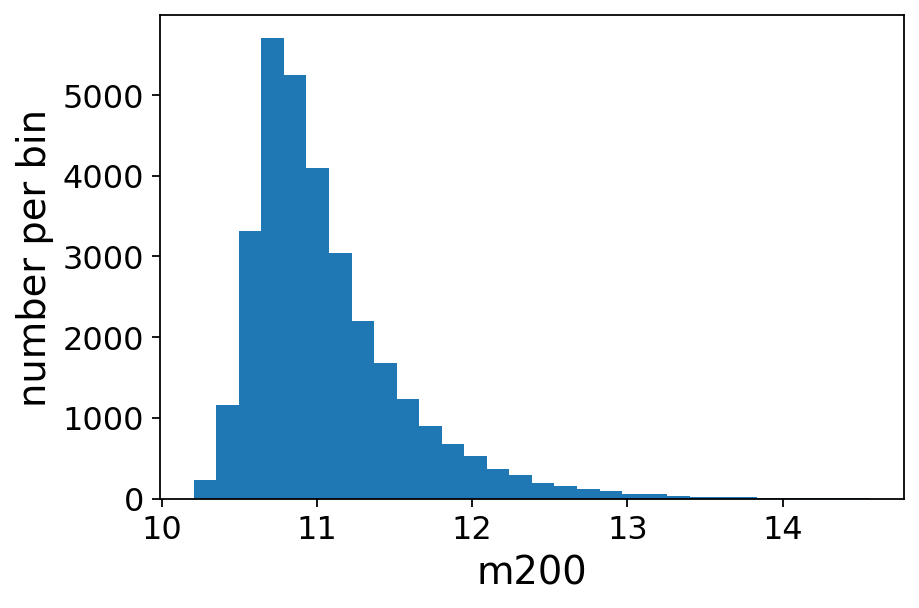

In [10]:
plt.hist(log_m_200m+log_mass_shift, bins=30)
plt.xlabel('m200')
plt.ylabel('number per bin')

# Multi gal label plots

In [11]:
feature_label_dict = {'scalars': 'Invariant scalar features',
                      'geos': 'Geometric features',
                      'catalog_z0': 'Standard halo features',
                      'mrv': 'M200, R200, V200'}

In [12]:
x_label_name = 'm_200m'
y_label_name_plot = ['m_stellar', 'ssfr1', 'r_stellar', 'gband_minus_iband', 'bhmass_per_mstellar', 'j_stellar']
y_label_name_arr = y_label_name_plot
y_label_name_train = '_'.join(y_label_name_arr)

In [16]:
frac_test = len(idx_test)/len(sim_reader.dark_halo_arr)
L_Mpc = sim_reader.box_size / 1000.0
weight = 1/(L_Mpc**3 * frac_test)
colorbar_label = 'galaxy number density\n'+r'[$h^{-1}$ Mpc)$^{-3}$ dex$^{-2}$]'

In [17]:
colors = ['black', 'maroon', 'lightseagreen', 'forestgreen']

## NN (multi-target, gaussian loss)

In [39]:
feature_modes = ['scalars']
# feature_modes = ['scalars', 'geos', 'catalog_z0', 'mrv']
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]

y_true_arr = []
y_pred_arr = []
text_results_arr = []

j_fiducial = feature_modes.index('scalars')
#j_fiducial = feature_modes.index('catalog_z0')

y_pred_feat_arr = []
for j in range(len(feature_labels)):
    feature_mode = feature_modes[j]
    fit_tag = ''
    #fit_tag = '_standardscaler'
    #fit_tag = '_minmaxscaler'
    if feature_mode=='geos':
        fit_tag += ''
    if feature_mode=='scalars':
        fit_tag += '_n3'
    #fit_tag += f'_{y_label_name_train}_tabnet_{feature_mode}_epochs500_lr0.02'
    #fit_tag += f'_{y_label_name_train}_rf_{feature_mode}'
    #fit_tag += f'_{y_label_name_train}_xgboost_{feature_mode}_lr0.01'
    #fit_tag += f'_{y_label_name_train}_hgboost_{feature_mode}_epochs300_lr0.1'
    fit_tag += f'_{y_label_name_train}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
    y_pred_all = np.load(fn_pred)
    y_pred_feat_arr.append(np.atleast_2d(y_pred_all))
    
y_pred_feat_arr = np.array(y_pred_feat_arr)

y_lowerlim_arr = []    
for y_label_name in y_label_name_plot:
    i = y_label_name_arr.index(y_label_name)
    y = utils.get_y_vals(y_label_name, sim_reader)
    y_test = y[idx_test]
    y_pred = y_pred_feat_arr[j_fiducial,:,i]
    y_pred_feats = y_pred_feat_arr[:,:,i]
    if y_label_name=='m_stellar':
        y_test += log_mass_shift
        y_pred_feats += log_mass_shift
    error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    
    x_bins, stdevs_binned = utils.get_butterfly_error(x_label_name, y_label_name, halo_logmass_min=10.2, n_bins=10)
    y_lowerlim_arr.append(stdevs_binned)
    
    y_true_arr.append(y_test)
    y_pred_arr.append(y_pred_feats)
    text_results_arr.append(error_str)

# x_bins_avg same for all, we'll just grab the last one
y_pred_arr = np.array(y_pred_arr)
x_property = log_m_200m[idx_test] + log_mass_shift

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:366: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


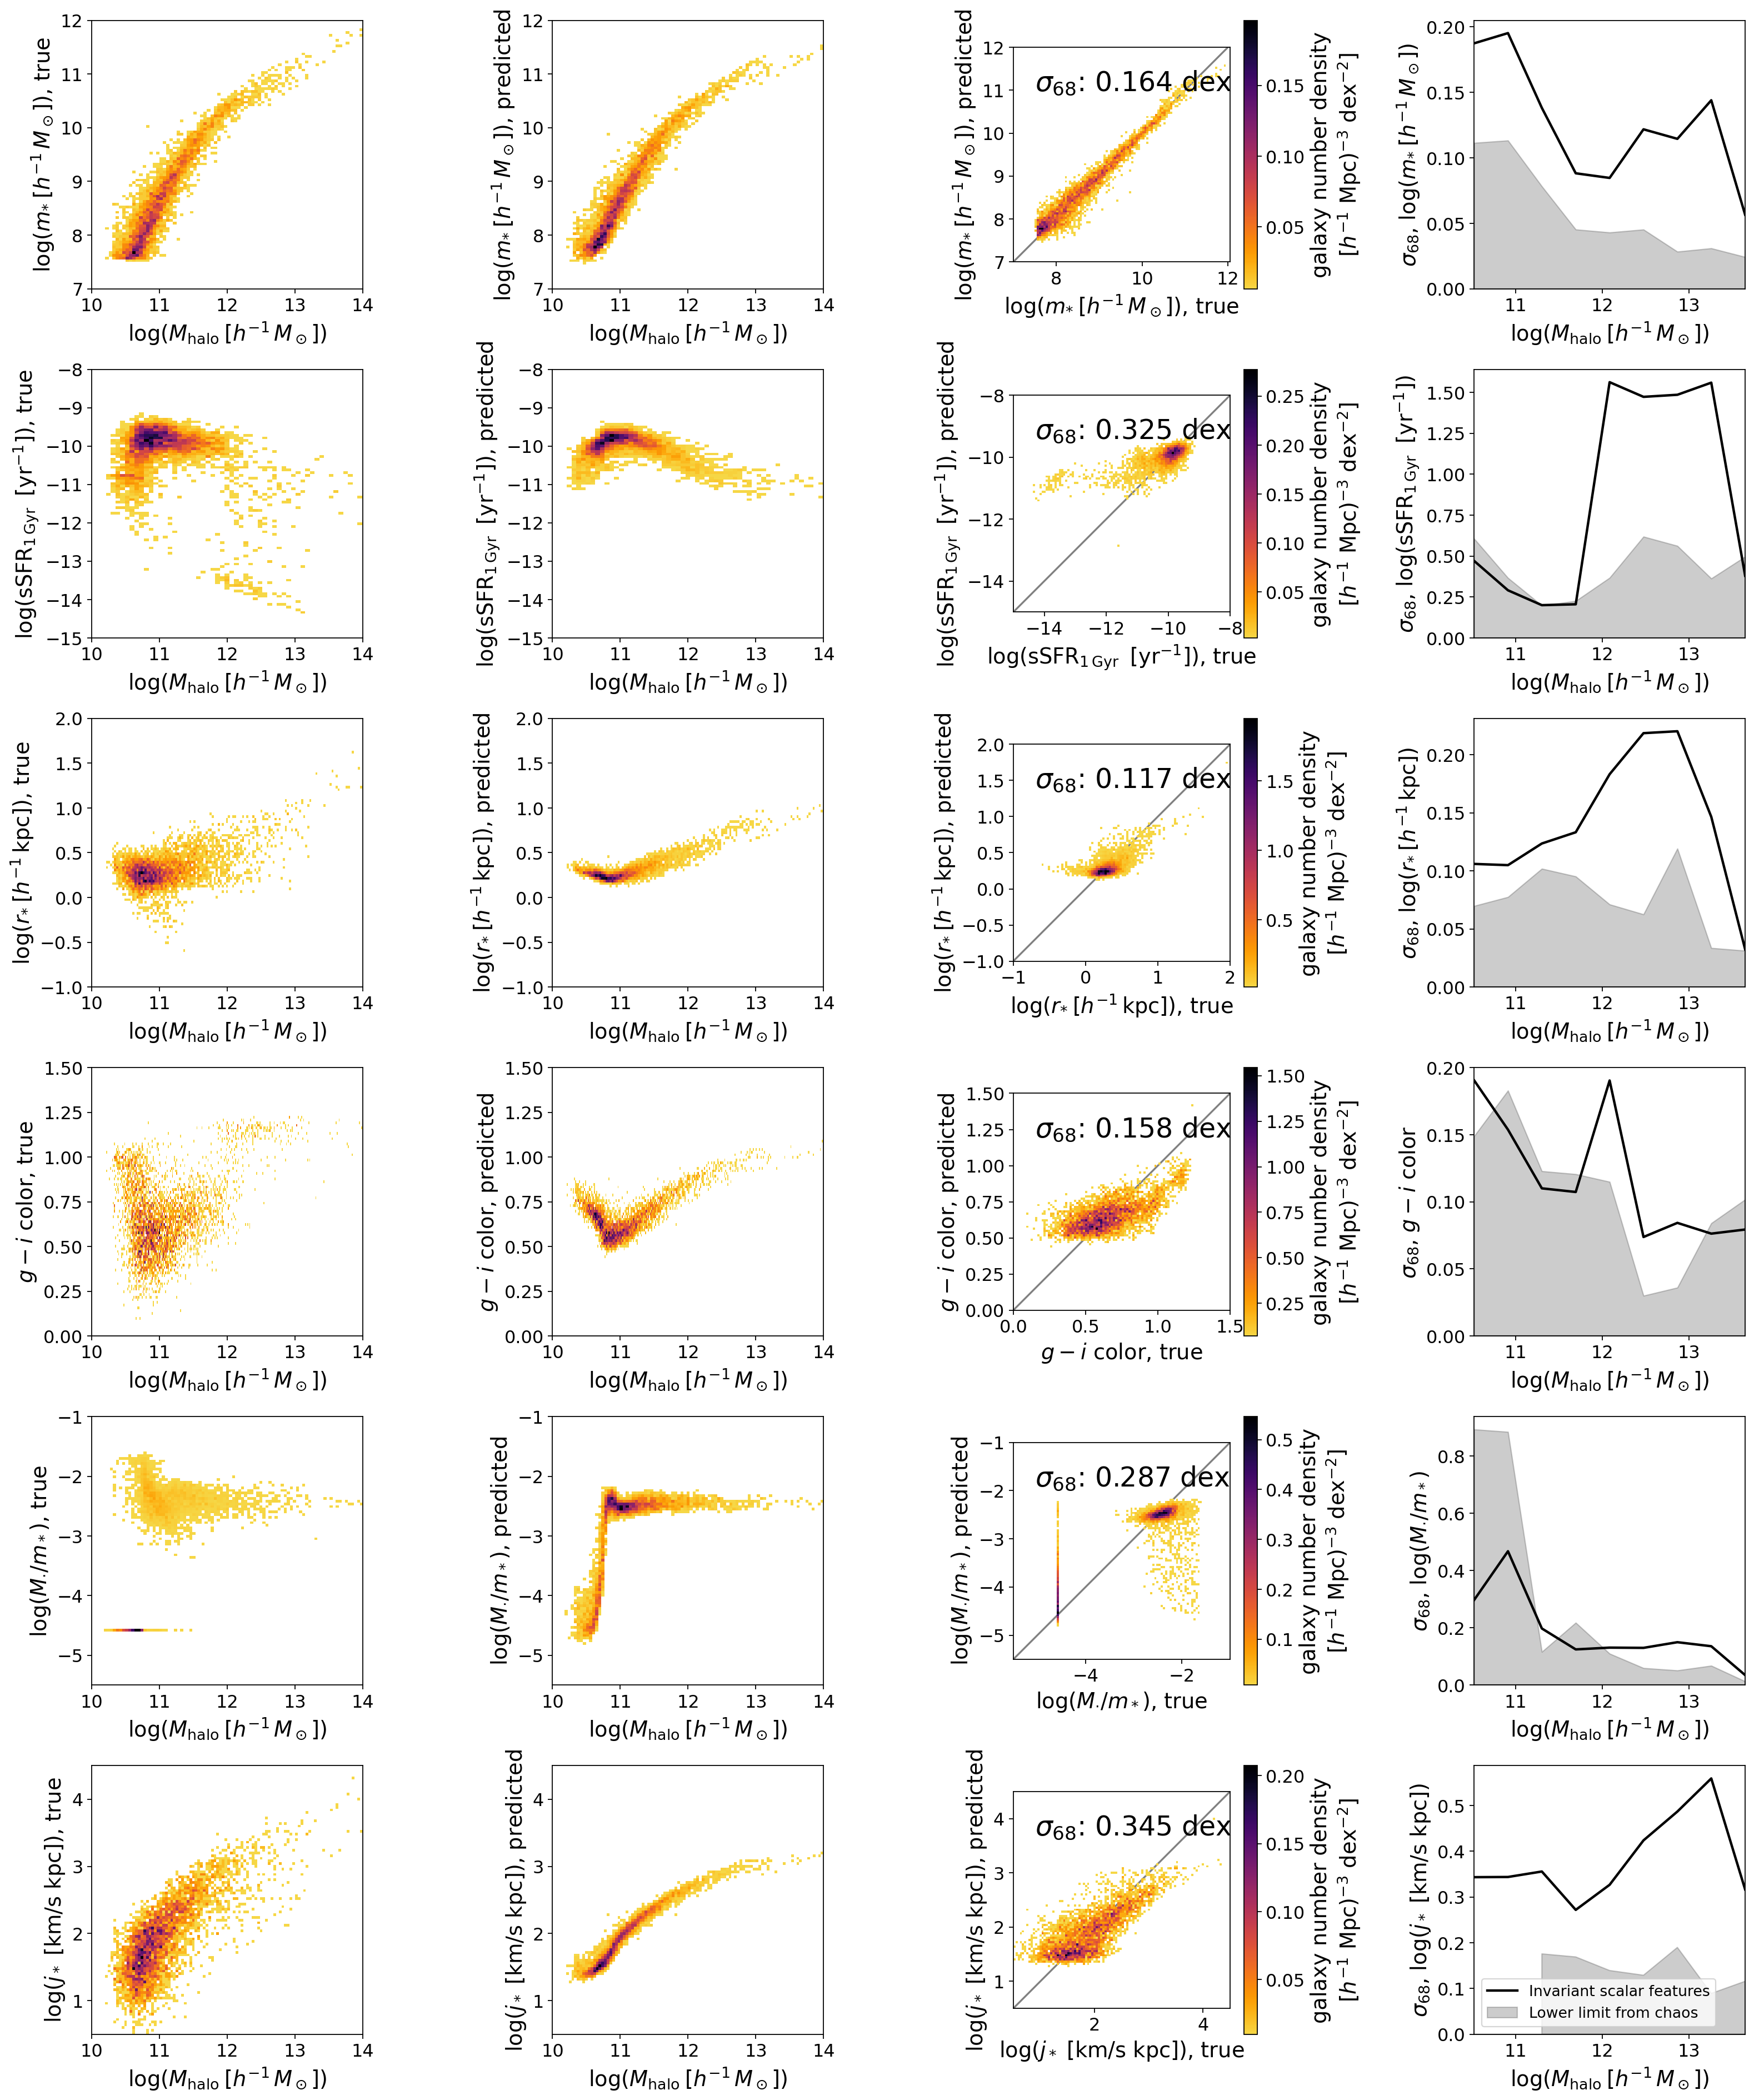

In [40]:
plotter.plot_multi_panel_gal_props_errors(x_label_name, y_label_name_plot, x_property, y_true_arr, y_pred_arr,
                                   feature_labels, colors,
                                   j_fiducial=j_fiducial,
                                   weight=weight, weight_by_dex=True, colorbar_label=colorbar_label,
                                   text_results_arr=text_results_arr,
                                   x_bins=x_bins, y_lowerlim_arr=y_lowerlim_arr)

## histgradboost (single-output, weighted)

In [27]:
feature_modes = ['scalars']
#feature_modes = ['scalars', 'geos', 'catalog_z0', 'mrv']
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]

y_true_arr = []
y_pred_arr = []
text_results_arr = []

j_fiducial = feature_modes.index('scalars')
#j_fiducial = feature_modes.index('catalog_z0')

y_pred_feat_arr = []
for j in range(len(feature_labels)):
    feature_mode = feature_modes[j]
    fit_tag = ''
    if feature_mode=='geos':
        fit_tag += ''
    if feature_mode=='scalars':
        fit_tag += '_n3'
    #fit_tag += f'_{y_label_name_train}_tabnet_{feature_mode}_epochs500_lr0.02'
    #fit_tag += f'_{y_label_name_train}_rf_{feature_mode}'
    #fit_tag += f'_{y_label_name_train}_xgboost_{feature_mode}_lr0.01'
    fit_tag += f'_{y_label_name_train}_hgboost_{feature_mode}_epochs300_lr0.1'
    #fit_tag += f'_{y_label_name_train}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
    y_pred_all = np.load(fn_pred)
    y_pred_feat_arr.append(np.atleast_2d(y_pred_all))
    
y_pred_feat_arr = np.array(y_pred_feat_arr)

y_lowerlim_arr = []    
for y_label_name in y_label_name_plot:
    i = y_label_name_arr.index(y_label_name)
    y = utils.get_y_vals(y_label_name, sim_reader)
    y_test = y[idx_test]
    y_pred = y_pred_feat_arr[j_fiducial,:,i]
    y_pred_feats = y_pred_feat_arr[:,:,i]
    if y_label_name=='m_stellar':
        y_test += log_mass_shift
        y_pred_feats += log_mass_shift
    error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    
    x_bins, stdevs_binned = utils.get_butterfly_error(x_label_name, y_label_name, halo_logmass_min=10.2, n_bins=10)
    y_lowerlim_arr.append(stdevs_binned)
    
    y_true_arr.append(y_test)
    y_pred_arr.append(y_pred_feats)
    text_results_arr.append(error_str)

# x_bins_avg same for all, we'll just grab the last one
y_pred_arr = np.array(y_pred_arr)
x_property = log_m_200m[idx_test] + log_mass_shift

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:366: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


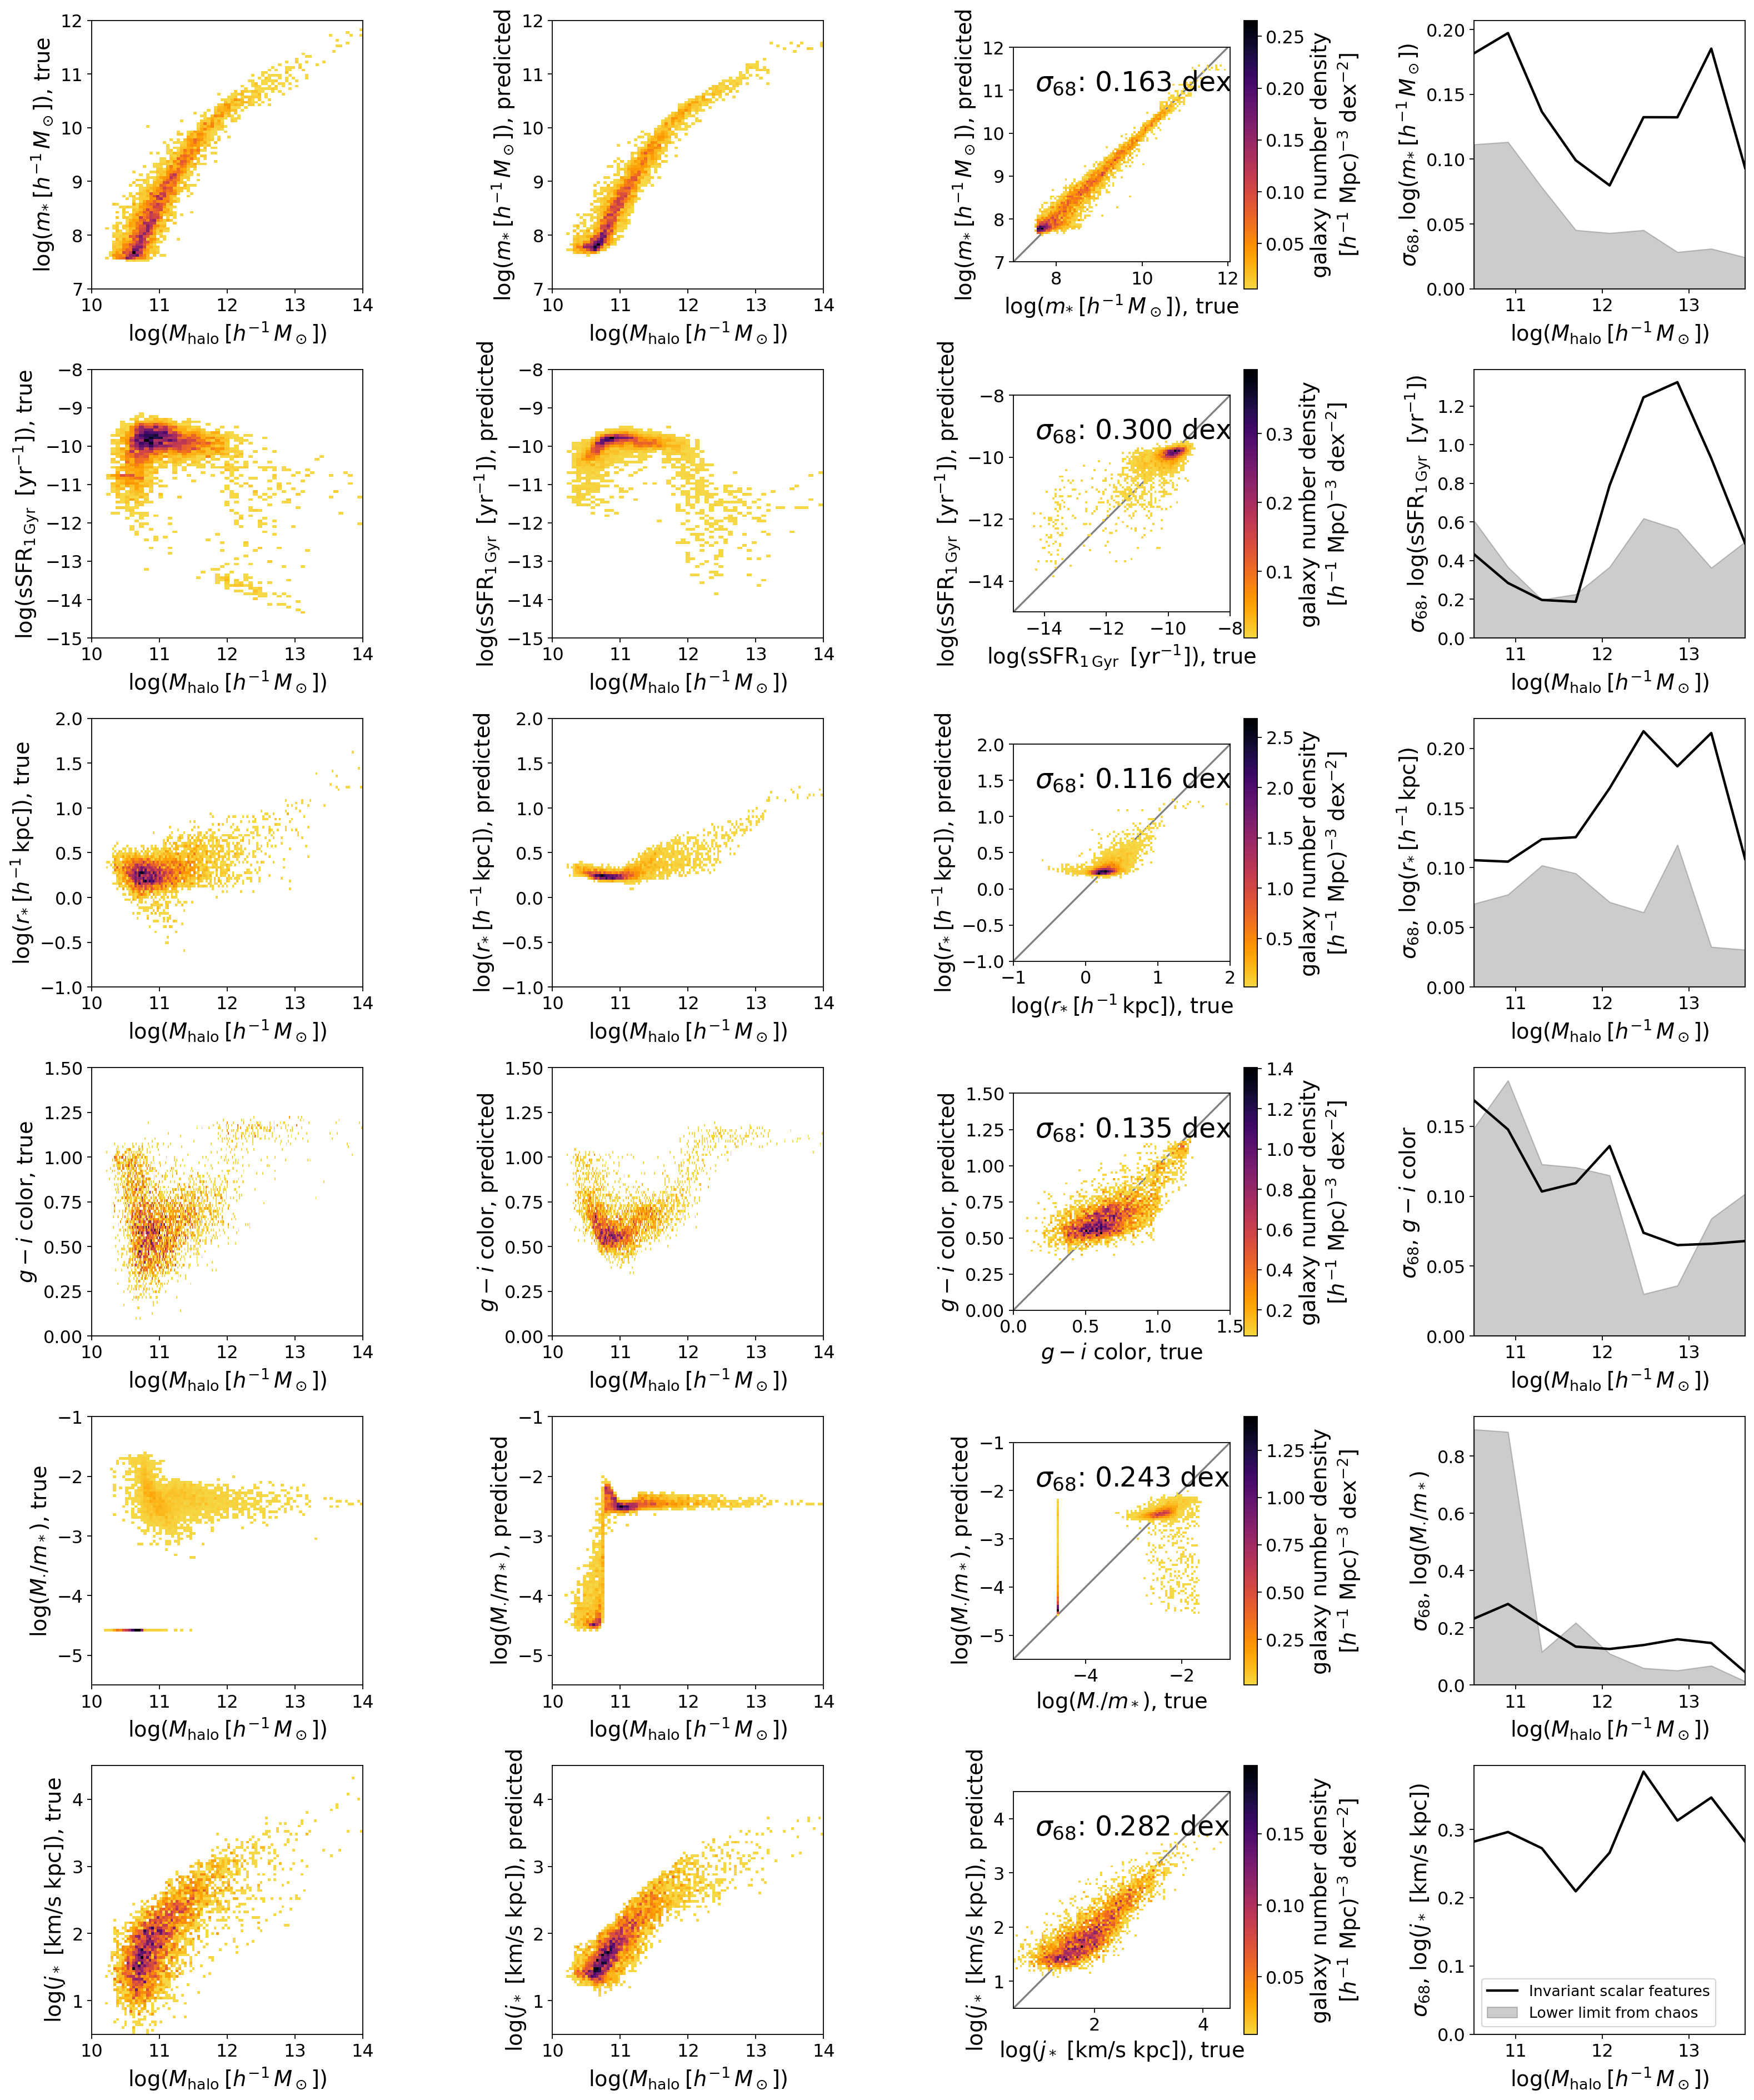

In [28]:
plotter.plot_multi_panel_gal_props_errors(x_label_name, y_label_name_plot, x_property, y_true_arr, y_pred_arr,
                                   feature_labels, colors,
                                   j_fiducial=j_fiducial,
                                   weight=weight, weight_by_dex=True, colorbar_label=colorbar_label,
                                   text_results_arr=text_results_arr,
                                   x_bins=x_bins, y_lowerlim_arr=y_lowerlim_arr)

# histgradboost (single-output, unweighted)

In [25]:
feature_modes = ['scalars']
#feature_modes = ['scalars', 'geos', 'catalog_z0', 'mrv']
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]

y_true_arr = []
y_pred_arr = []
text_results_arr = []

j_fiducial = feature_modes.index('scalars')
#j_fiducial = feature_modes.index('catalog_z0')

y_pred_feat_arr = []
for j in range(len(feature_labels)):
    feature_mode = feature_modes[j]
    fit_tag = '_unweighted'
    if feature_mode=='geos':
        fit_tag += ''
    if feature_mode=='scalars':
        fit_tag += '_n3'
    fit_tag += f'_{y_label_name_train}_hgboost_{feature_mode}_epochs300_lr0.1'
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
    y_pred_all = np.load(fn_pred)
    y_pred_feat_arr.append(np.atleast_2d(y_pred_all))
    
y_pred_feat_arr = np.array(y_pred_feat_arr)

y_lowerlim_arr = []    
for y_label_name in y_label_name_plot:
    i = y_label_name_arr.index(y_label_name)
    y = utils.get_y_vals(y_label_name, sim_reader)
    y_test = y[idx_test]
    y_pred = y_pred_feat_arr[j_fiducial,:,i]
    y_pred_feats = y_pred_feat_arr[:,:,i]
    if y_label_name=='m_stellar':
        y_test += log_mass_shift
        y_pred_feats += log_mass_shift
    error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    
    x_bins, stdevs_binned = utils.get_butterfly_error(x_label_name, y_label_name, halo_logmass_min=10.2, n_bins=10)
    y_lowerlim_arr.append(stdevs_binned)
    
    y_true_arr.append(y_test)
    y_pred_arr.append(y_pred_feats)
    text_results_arr.append(error_str)

# x_bins_avg same for all, we'll just grab the last one
y_pred_arr = np.array(y_pred_arr)
x_property = log_m_200m[idx_test] + log_mass_shift

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:366: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


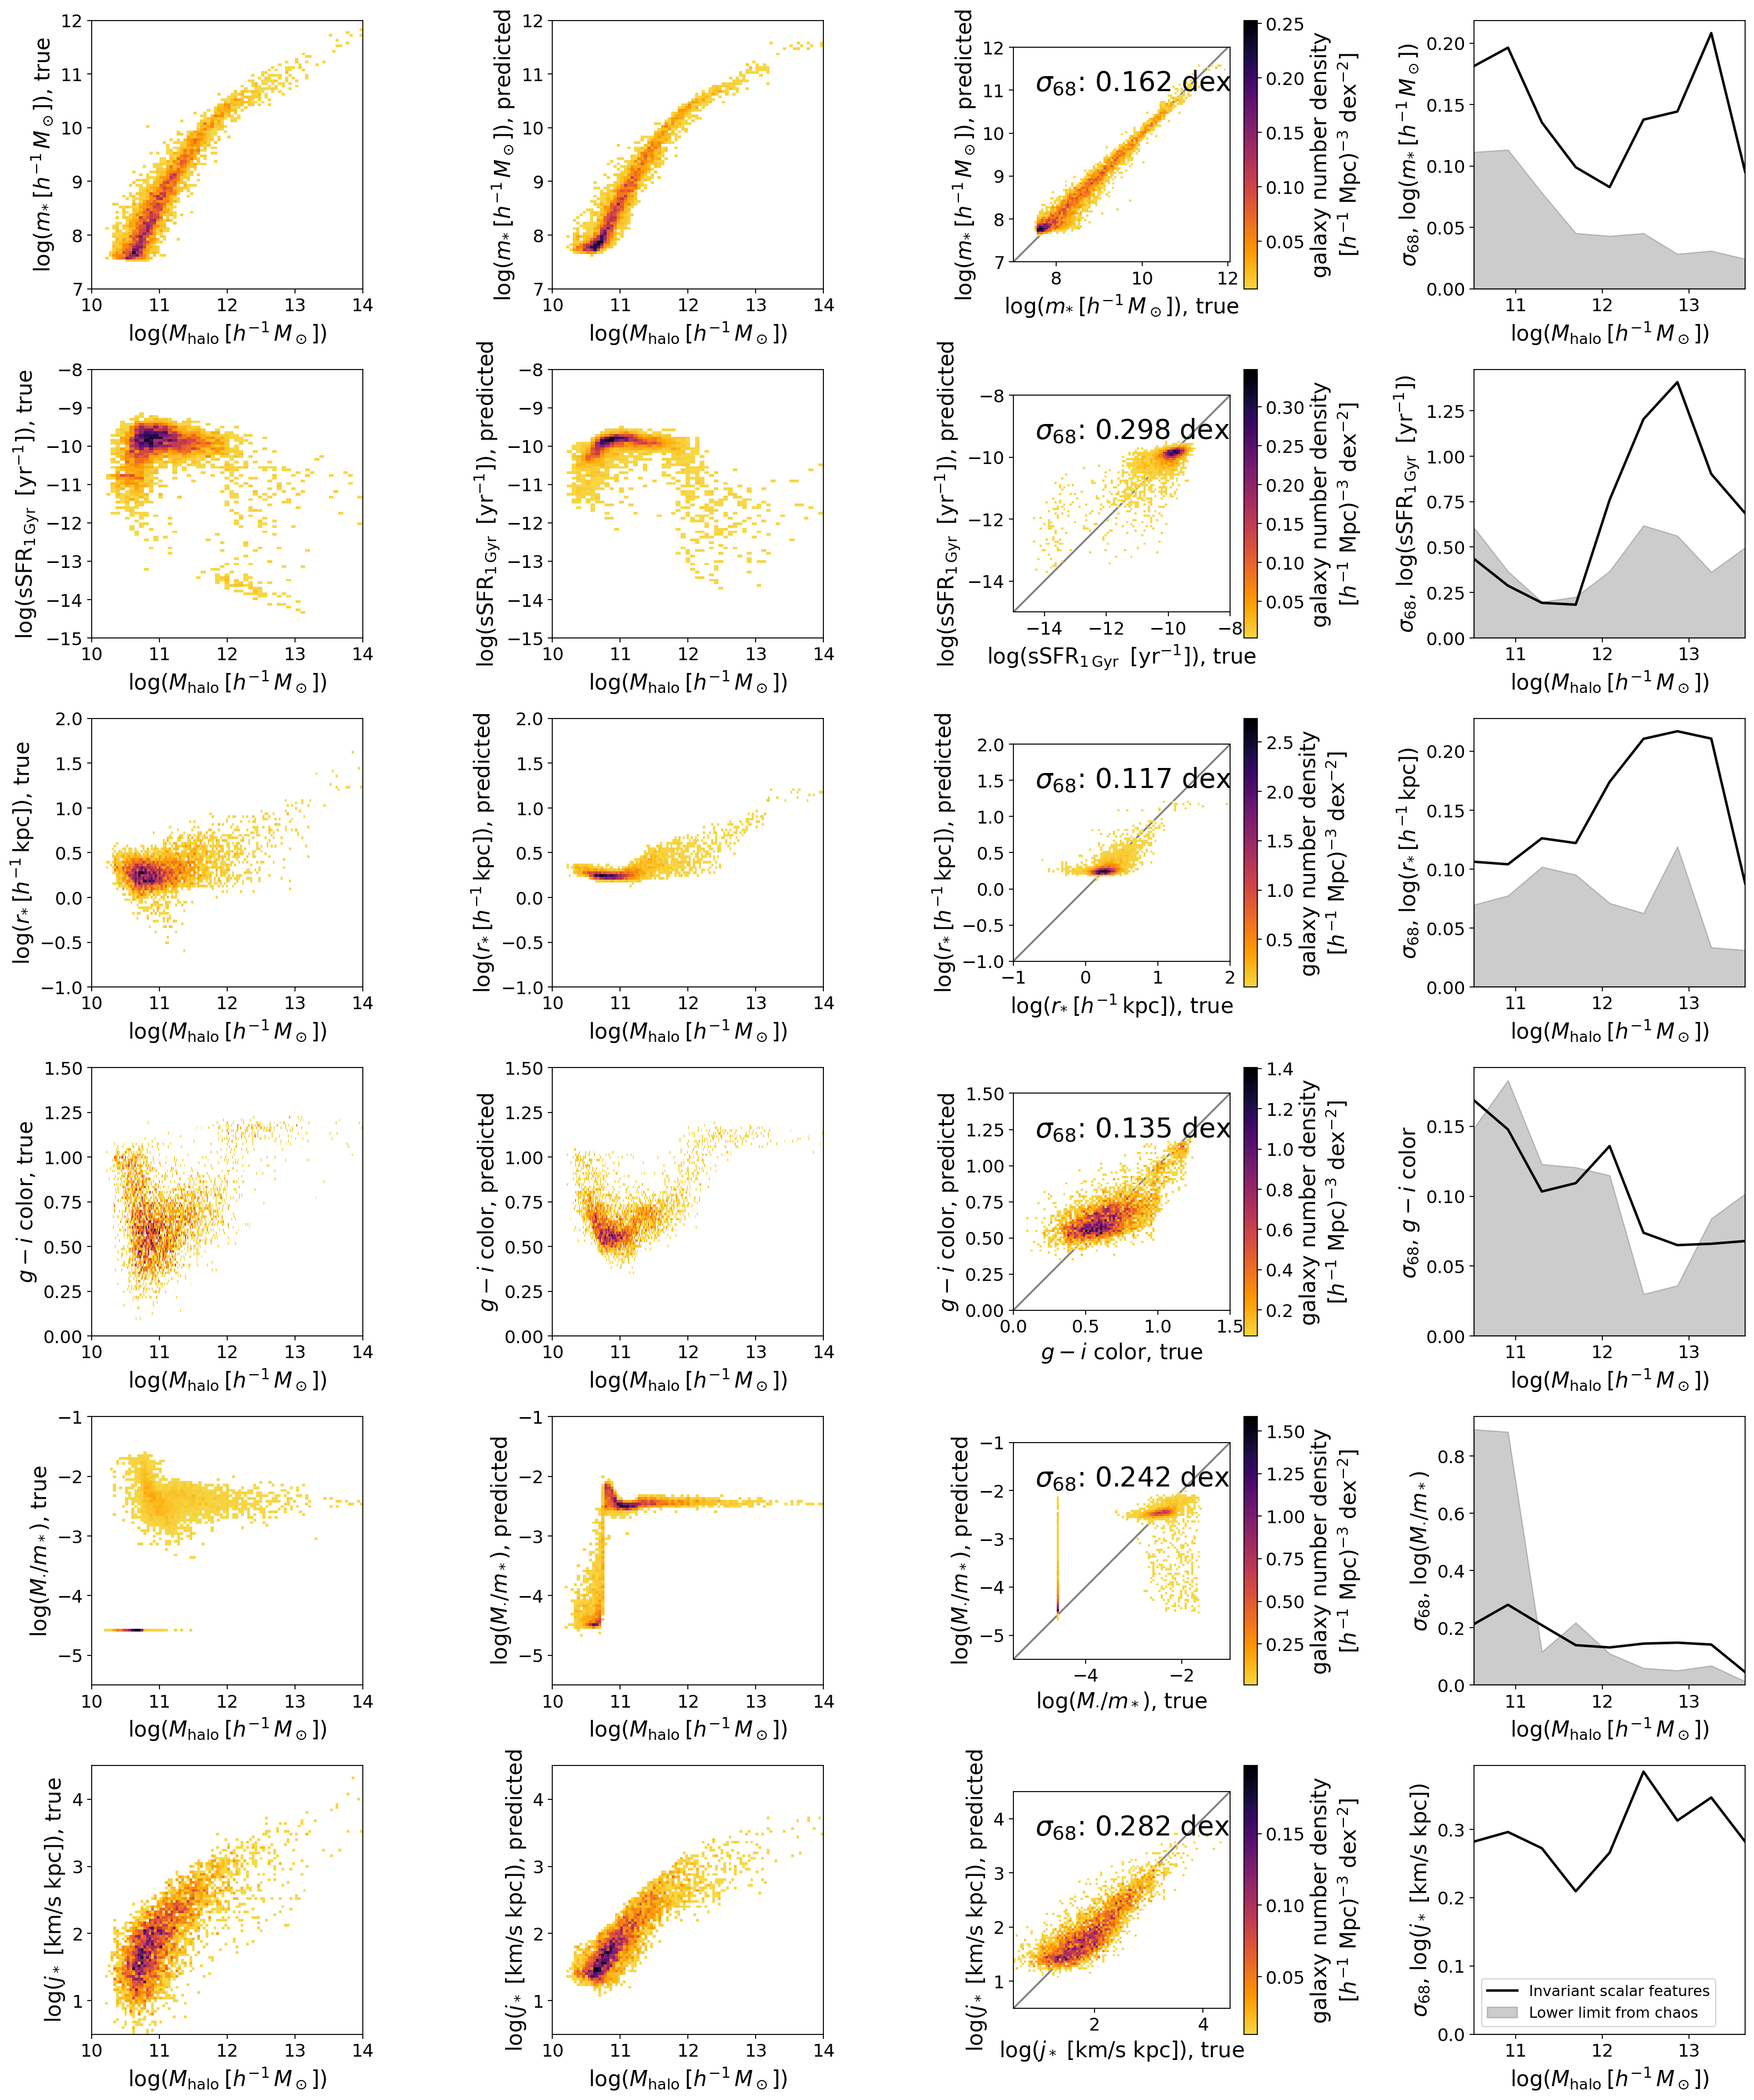

In [26]:
plotter.plot_multi_panel_gal_props_errors(x_label_name, y_label_name_plot, x_property, y_true_arr, y_pred_arr,
                                   feature_labels, colors,
                                   j_fiducial=j_fiducial,
                                   weight=weight, weight_by_dex=True, colorbar_label=colorbar_label,
                                   text_results_arr=text_results_arr,
                                   x_bins=x_bins, y_lowerlim_arr=y_lowerlim_arr)

# xgboost (multi-label, unweighted)

In [33]:
feature_modes = ['scalars']
#feature_modes = ['scalars', 'geos', 'catalog_z0', 'mrv']
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]

y_true_arr = []
y_pred_arr = []
text_results_arr = []

j_fiducial = feature_modes.index('scalars')
#j_fiducial = feature_modes.index('catalog_z0')

y_pred_feat_arr = []
for j in range(len(feature_labels)):
    feature_mode = feature_modes[j]
    fit_tag = ''
    if feature_mode=='geos':
        fit_tag += ''
    if feature_mode=='scalars':
        fit_tag += '_n3'
    fit_tag += f'_{y_label_name_train}_xgboost_{feature_mode}_lr0.02'
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
    y_pred_all = np.load(fn_pred)
    y_pred_feat_arr.append(np.atleast_2d(y_pred_all))
    
y_pred_feat_arr = np.array(y_pred_feat_arr)

y_lowerlim_arr = []    
for y_label_name in y_label_name_plot:
    i = y_label_name_arr.index(y_label_name)
    y = utils.get_y_vals(y_label_name, sim_reader)
    y_test = y[idx_test]
    y_pred = y_pred_feat_arr[j_fiducial,:,i]
    y_pred_feats = y_pred_feat_arr[:,:,i]
    if y_label_name=='m_stellar':
        y_test += log_mass_shift
        y_pred_feats += log_mass_shift
    error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    
    x_bins, stdevs_binned = utils.get_butterfly_error(x_label_name, y_label_name, halo_logmass_min=10.2, n_bins=10)
    y_lowerlim_arr.append(stdevs_binned)
    
    y_true_arr.append(y_test)
    y_pred_arr.append(y_pred_feats)
    text_results_arr.append(error_str)

# x_bins_avg same for all, we'll just grab the last one
y_pred_arr = np.array(y_pred_arr)
x_property = log_m_200m[idx_test] + log_mass_shift

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:366: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


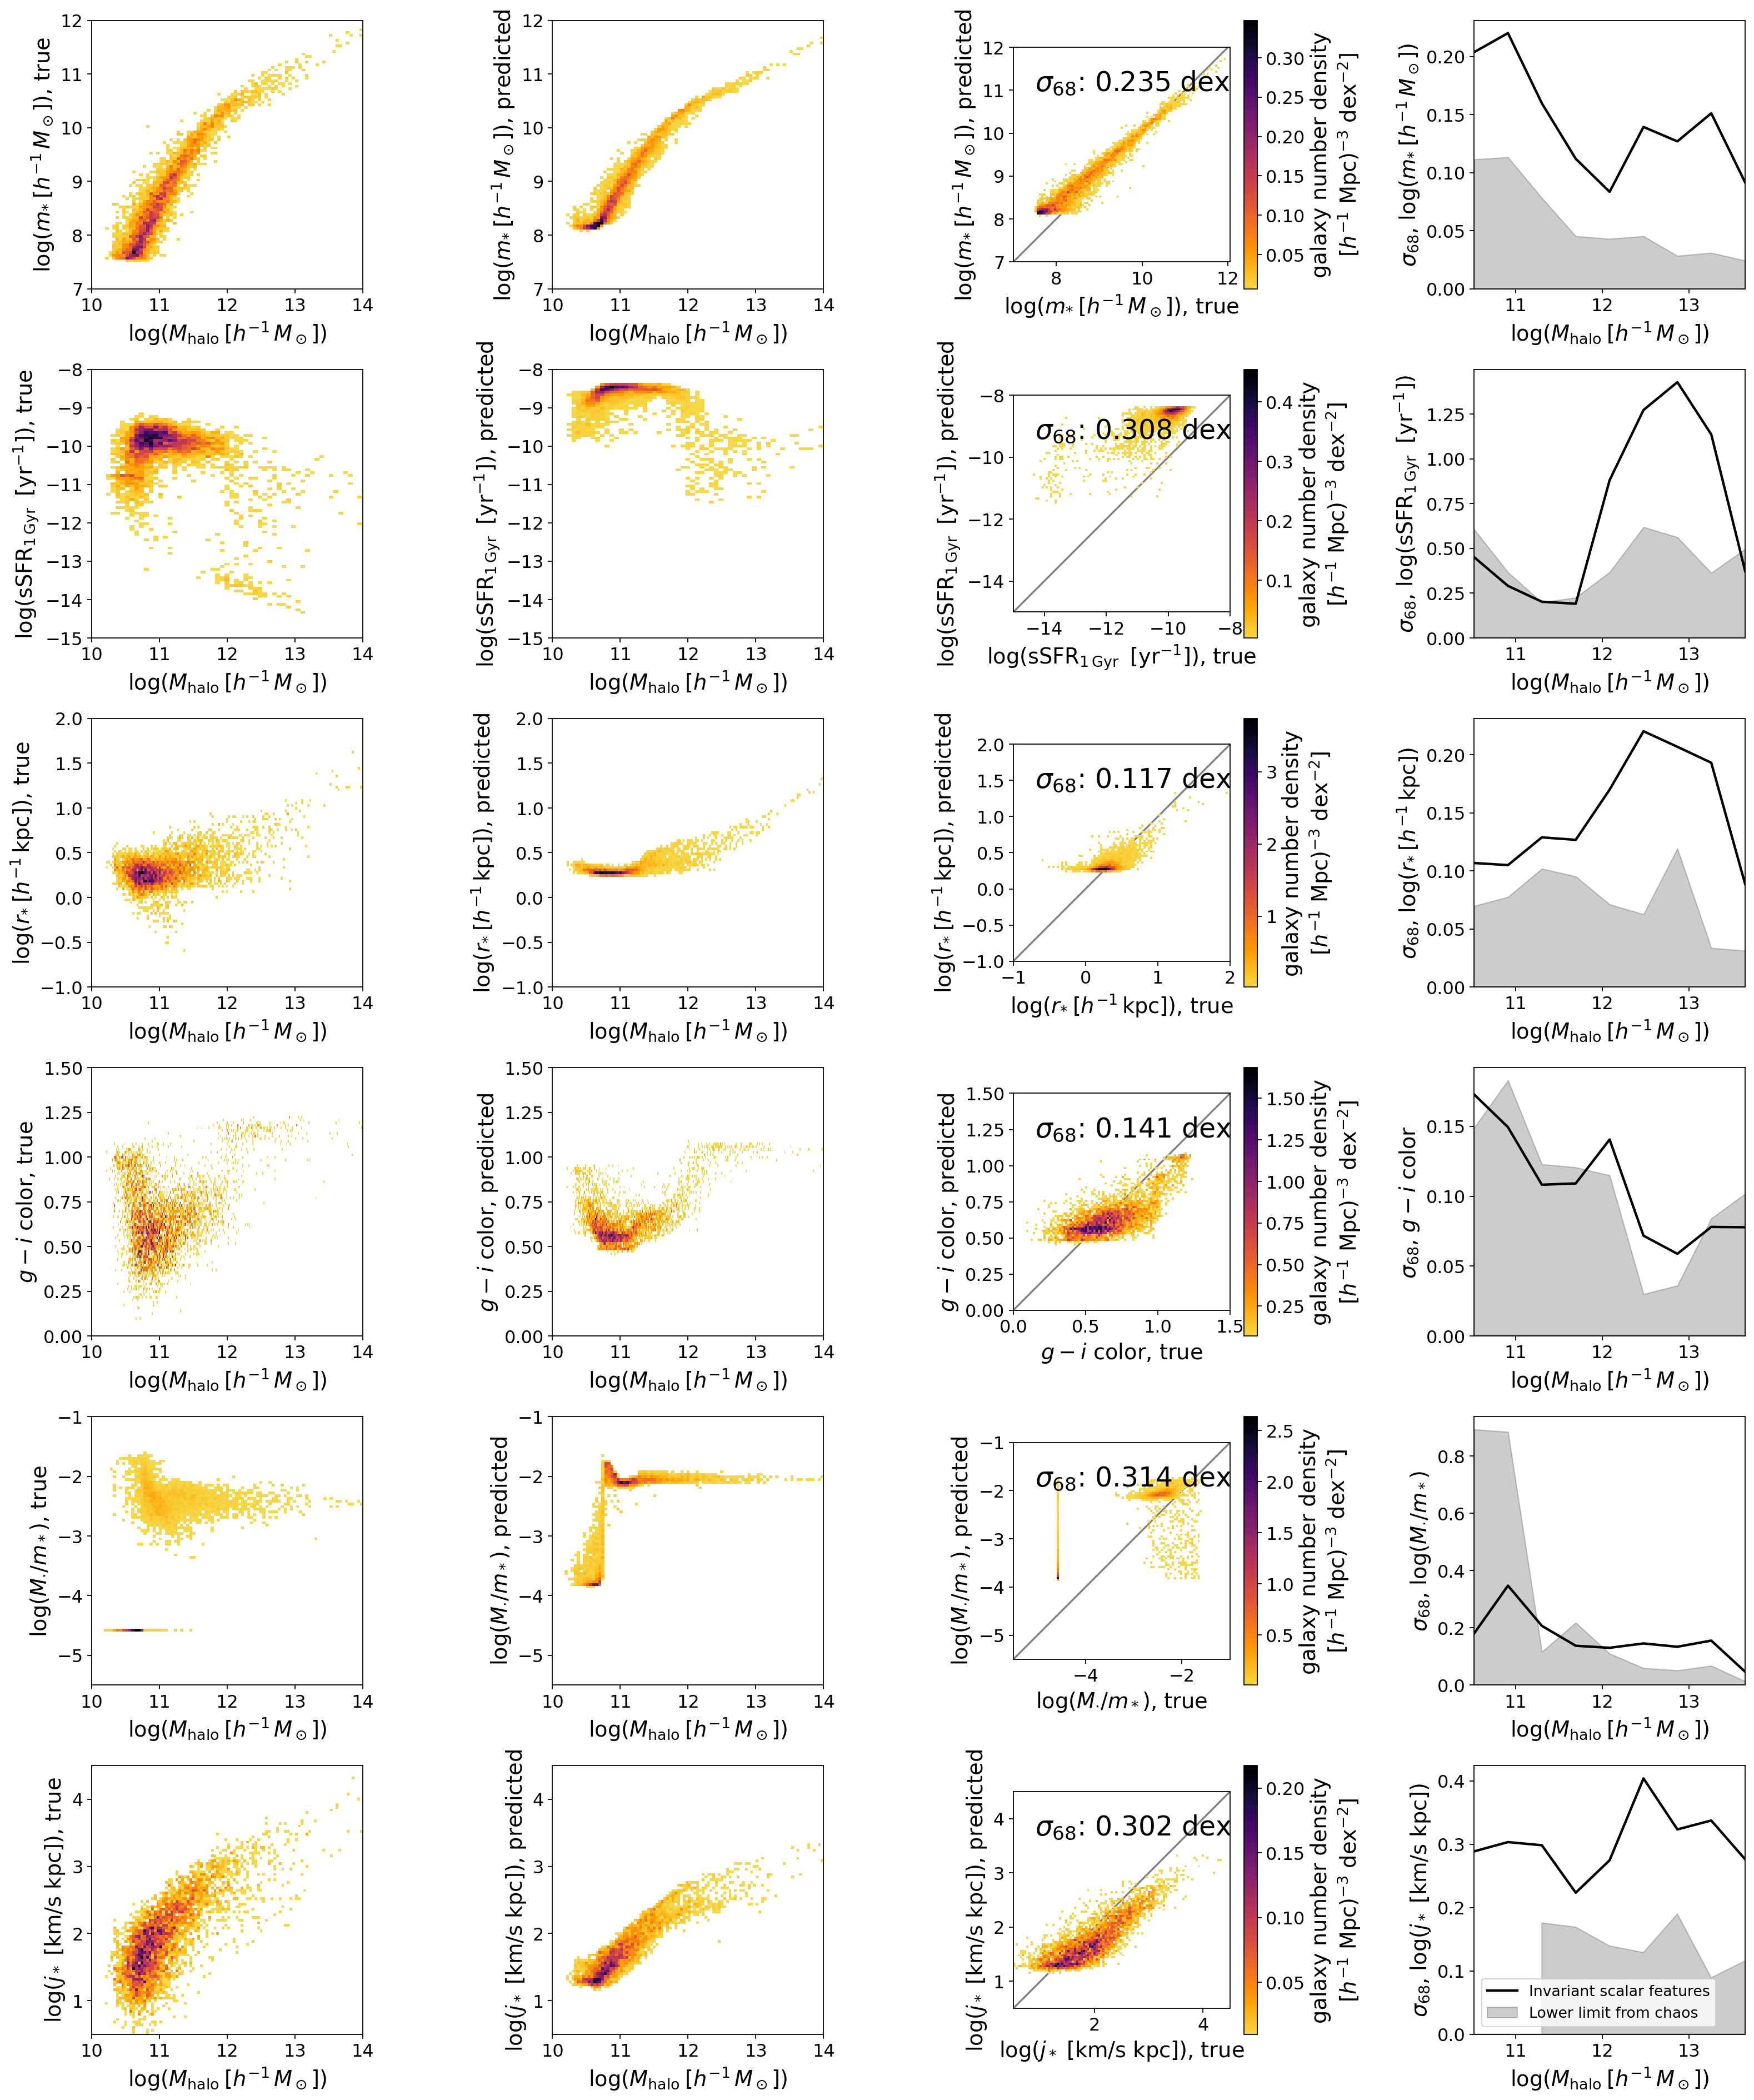

In [34]:
plotter.plot_multi_panel_gal_props_errors(x_label_name, y_label_name_plot, x_property, y_true_arr, y_pred_arr,
                                   feature_labels, colors,
                                   j_fiducial=j_fiducial,
                                   weight=weight, weight_by_dex=True, colorbar_label=colorbar_label,
                                   text_results_arr=text_results_arr,
                                   x_bins=x_bins, y_lowerlim_arr=y_lowerlim_arr)

# tabnet (multi-label, unweighted)

In [23]:
feature_modes = ['scalars']
#feature_modes = ['scalars', 'geos', 'catalog_z0', 'mrv']
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]

y_true_arr = []
y_pred_arr = []
text_results_arr = []

j_fiducial = feature_modes.index('scalars')
#j_fiducial = feature_modes.index('catalog_z0')

y_pred_feat_arr = []
for j in range(len(feature_labels)):
    feature_mode = feature_modes[j]
    fit_tag = ''
    if feature_mode=='geos':
        fit_tag += ''
    if feature_mode=='scalars':
        fit_tag += '_n3'
    #fit_tag += f'_{y_label_name_train}_tabnet_{feature_mode}_epochs500_lr0.02'
    #fit_tag += f'_{y_label_name_train}_rf_{feature_mode}'
    #fit_tag += f'_{y_label_name_train}_xgboost_{feature_mode}_lr0.01'
    fit_tag += f'_{y_label_name_train}_hgboost_{feature_mode}_epochs300_lr0.1'
    #fit_tag += f'_{y_label_name_train}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
    y_pred_all = np.load(fn_pred)
    y_pred_feat_arr.append(np.atleast_2d(y_pred_all))
    
y_pred_feat_arr = np.array(y_pred_feat_arr)

y_lowerlim_arr = []    
for y_label_name in y_label_name_plot:
    i = y_label_name_arr.index(y_label_name)
    y = utils.get_y_vals(y_label_name, sim_reader)
    y_test = y[idx_test]
    y_pred = y_pred_feat_arr[j_fiducial,:,i]
    y_pred_feats = y_pred_feat_arr[:,:,i]
    if y_label_name=='m_stellar':
        y_test += log_mass_shift
        y_pred_feats += log_mass_shift
    error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    
    x_bins, stdevs_binned = utils.get_butterfly_error(x_label_name, y_label_name, halo_logmass_min=10.2, n_bins=10)
    y_lowerlim_arr.append(stdevs_binned)
    
    y_true_arr.append(y_test)
    y_pred_arr.append(y_pred_feats)
    text_results_arr.append(error_str)

# x_bins_avg same for all, we'll just grab the last one
y_pred_arr = np.array(y_pred_arr)
x_property = log_m_200m[idx_test] + log_mass_shift

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:366: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


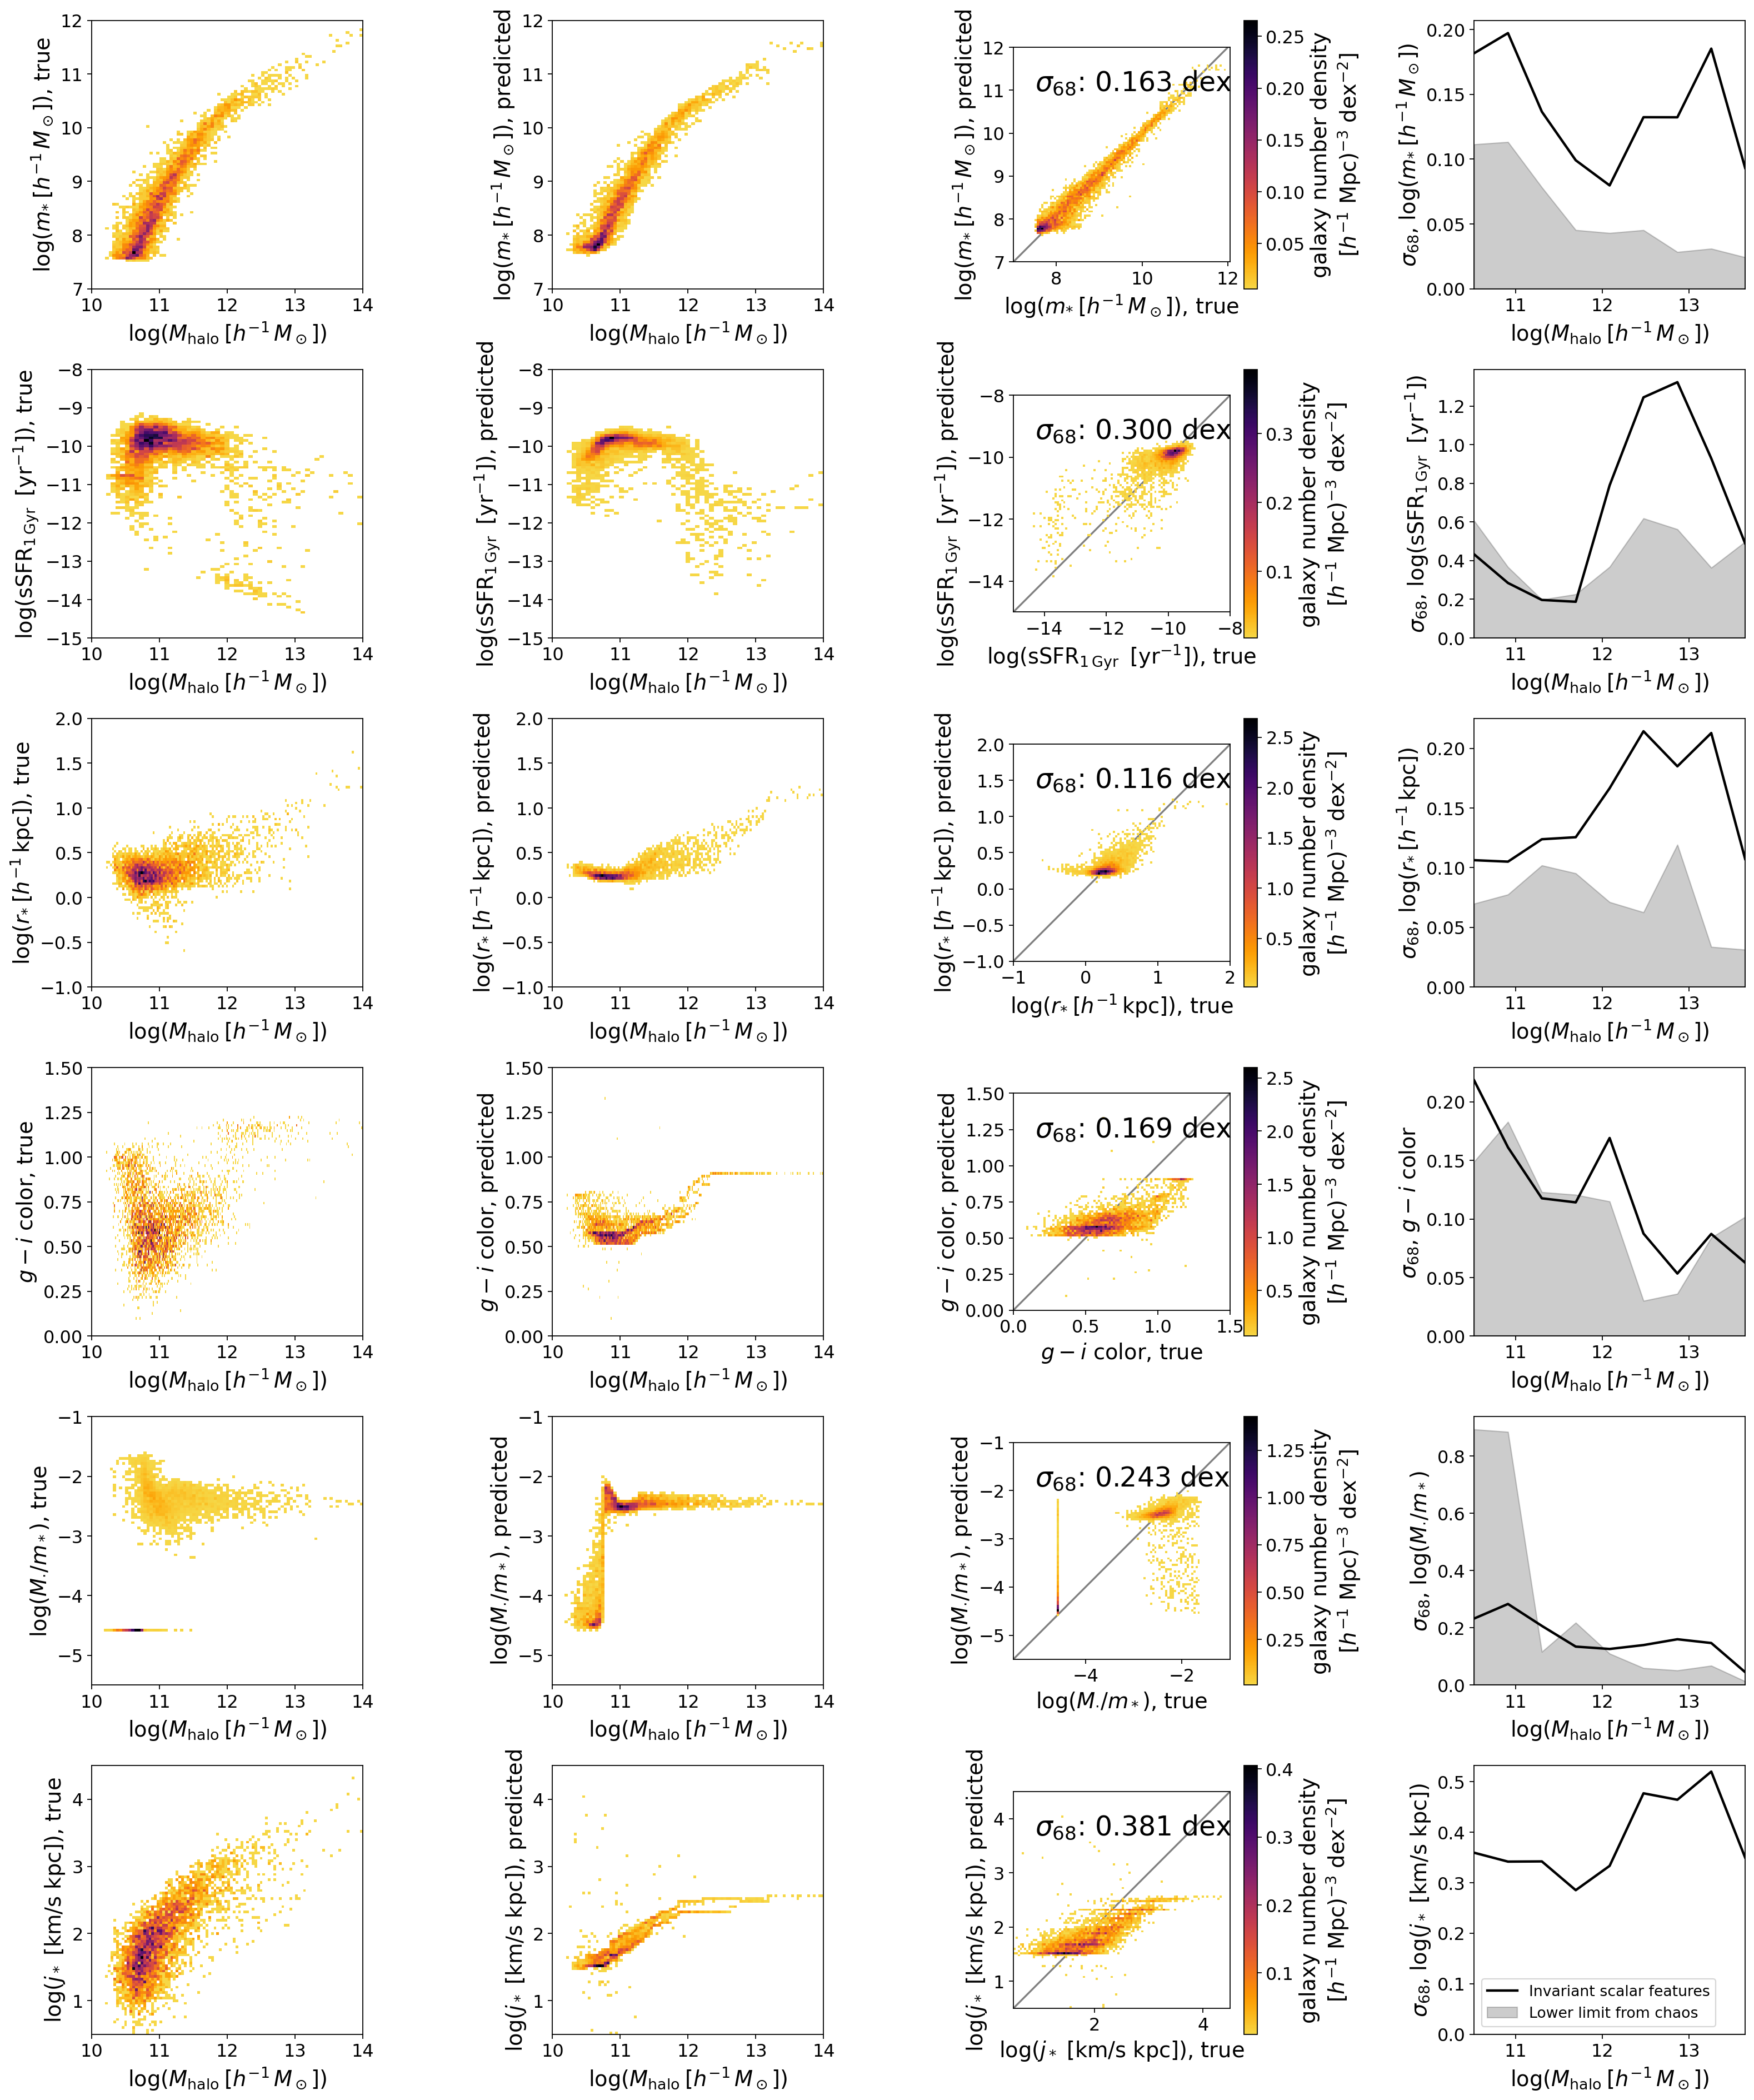

In [24]:
plotter.plot_multi_panel_gal_props_errors(x_label_name, y_label_name_plot, x_property, y_true_arr, y_pred_arr,
                                   feature_labels, colors,
                                   j_fiducial=j_fiducial,
                                   weight=weight, weight_by_dex=True, colorbar_label=colorbar_label,
                                   text_results_arr=text_results_arr,
                                   x_bins=x_bins, y_lowerlim_arr=y_lowerlim_arr)